Assignment E02

Implement the Zero-crossing rate (ZCR) feature to describe a single-channel audio signal, starting from the commands shown in the excercises.
Verify the effect of using ZCR in combination with other features available in the published notebook.

In [ ]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

# Advanced audio features
import librosa
import librosa.display as lid
from sklearn.preprocessing import scale

In [ ]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
copyfile('gdrive/MyDrive/recordings.tar', 'recordings.tar')

'recordings.tar'

In [ ]:
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

In [ ]:
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

In [ ]:
def crop(input, size=100):
    # Remove any values exceeding the given limit
    output = input[0:min(size, input.shape[0])]
    # Add null values (padding) in order to reach the requested size
    output = np.concatenate((output, np.zeros(size-output.shape[0])))
    return output

In [ ]:
def sdev(input):
    return np.std(input, keepdims=True)

-	Scalar quantity: it has only one characteristic, the modulus value.
- Vector quantity: has 3 characteristics modulus, direction and direction.

scikit-learn classifiers cannot directly use a scalar feature.
They can, however, use an equivalent monodimensional vector with size = 1.

The effect of using keepdims=True during the feature computation is shown here:

In [ ]:
# Create sample data and corresponding feature
dummy_data = np.random.rand(100)
feats_scalar = np.std(dummy_data)
feats_vector = np.std(dummy_data, keepdims=True)

In [ ]:
# Scalar feature
print(feats_scalar)
print(feats_scalar.shape)

0.2843171763032851
()


In [ ]:
# Vector feature
print(feats_vector)
print(feats_vector.shape)

[0.28431718]
(1,)


The average value of an audio signal is typically close to zero, since the signal oscillates around such value.

A more interesting feature could be the average of the absolute values (avg()).

Note: by definition, this feature is highly correlated to the "volume" of the audio track.

In [ ]:
def avg(input):
    return np.mean(input, keepdims=True)

def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

In [ ]:
def duration(input):
    return input.shape

def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

def zcr(input):
    return input # TODO

Zero-Crossing Rate: count how many times the signal goes from positive to negative, and from negative to positive.

Possible approach:

- Shift the signal by one unit
- Compare point-by-point the sign (np.sign()) of the original signal and of the shifted signal
- Accumulate the instances of sign change

# Zero-Crossing Rate (ZCR)
[10 14 5 -5 -7 10]  
[14 5 -5 -7 10  0]
# + +  +  -  -  +
# + +  -  -  +  +  

  0 0  1  0  1  0

Adding up the result will give zcr=2

Zero-crossing rate (ZCR):   
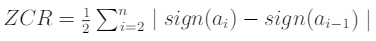  
It is a measure that reﬂects the times that signs of two adjacent values in A change from positive to negative or vice versa where sign() returns 1 if one of the two inputs is positive and another one is negative;otherwise it returns 0.

In [ ]:
def zcr (input):
  return np.sum(np.abs(np.diff(input, n=1)), keepdims=True)/2

In [ ]:
def combo_without_zrc(input):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input)))

In [ ]:
def combo(input):
    return np.concatenate((aavg(input),sdev(input),duration(input),energy(input),zcr(input)))

# Model training

In [ ]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor=combo_without_zrc, normalize=True)
X_train_zcr, X_test_zcr, y_train_zcr, y_test_zcr = load_data(feature_extractor=combo, normalize=True)

In [ ]:
# Dimensionality of the training features
print(X_train[0].shape)
print(X_train_zcr[0].shape)

(4,)
(5,)


For training without zcr there will be 4 features  
For training with zcr there will be 5 features

In [ ]:
# Parameters to be tested in cross-validation without zcr
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf_without_zcr = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf_without_zcr = clf_without_zcr.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 3.629s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf_without_zcr.best_estimator_.C))
print(' gamma: '+str(clf_without_zcr.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 0.5


In [ ]:
# Parameters to be tested in cross-validation without zcr
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train_zcr, y_train_zcr)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 2.914s


In [ ]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 1000
 gamma: 0.1


# Model testing

## Test without ZCR

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.65      0.61        17
           1       0.33      0.40      0.36        10
           2       0.28      0.33      0.30        15
           3       0.53      0.42      0.47        19
           4       0.36      0.45      0.40        11
           5       0.44      0.29      0.35        14
           6       0.79      0.79      0.79        14
           7       0.80      0.42      0.55        19
           8       0.35      0.41      0.38        17
           9       0.32      0.43      0.36        14

    accuracy                           0.46       150
   macro avg       0.48      0.46      0.46       150
weighted avg       0.49      0.46      0.47       150

Confusion matrix:
[[11  0  0  0  0  0  0  0  0  6]
 [ 0  4  2  2  0  1  0  0  1  0]
 [ 2  1  5  3  0  0  0  0  2  2]
 [ 0  3  7  8  0  0  0  0  0  1]
 [ 1  1  1  1  5  2  0  0  0  0]
 [ 1  0  0  1  4  4  1  0  2  1]
 [

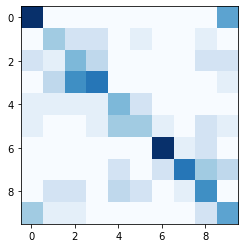

In [ ]:
# Test
y_pred = clf_without_zcr.predict(X_test)

# Classificaiton report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

## Test with ZCR

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69        17
           1       0.29      0.50      0.37        10
           2       0.78      0.47      0.58        15
           3       0.75      0.63      0.69        19
           4       0.35      0.55      0.43        11
           5       0.54      0.50      0.52        14
           6       0.83      0.71      0.77        14
           7       0.58      0.58      0.58        19
           8       0.43      0.35      0.39        17
           9       0.50      0.64      0.56        14

    accuracy                           0.56       150
   macro avg       0.58      0.56      0.56       150
weighted avg       0.60      0.56      0.57       150

Confusion matrix:
[[11  0  0  0  1  1  0  0  0  4]
 [ 0  5  0  1  3  0  0  0  1  0]
 [ 2  1  7  2  0  1  0  0  1  1]
 [ 0  4  1 12  1  0  0  0  0  1]
 [ 1  2  1  1  6  0  0  0  0  0]
 [ 0  0  0  0  2  7  1  0  3  1]
 [

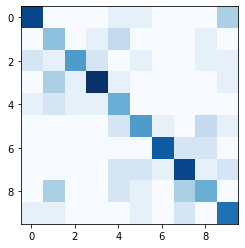

In [ ]:
# Test
y_pred = clf.predict(X_test_zcr)

# Classificaiton report
print('Classification report:')
print(classification_report(y_test_zcr, y_pred))

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(y_test_zcr, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

As you can see from these 2 tests by adding the Zero-Crossing Rate feature the accuracy increases significantly from 0.46 (model without ZCR) to 0.56 (model with ZCR).